In [1]:
import numpy as np
from polyphys.probe.prober import fsd
from polyphys.analyze import correlations
import MDAnalysis as mda
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis import transformations as mda_trans
import statsmodels.tsa.stattools as tsas

from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

# Radius of gyration:

In [3]:
glob('/Users/amirhsi_mini/research_data/test_hns_cyl/*')

['/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc5760ens5.ring.all-original.data',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc5760ens5.ring',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring.all.data',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1l250nc0ens1.ring-minimizing_dna',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1r8lz675nc0ens1.ring-minimizing_dna']

In [3]:
# free
glob('/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1l250nc0ens1.ring/N*')

['/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1l250nc0ens1.ring/N1000kbmm24nh0ac1l250nc0ens1.ring.lammpstrj',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1l250nc0ens1.ring/N1000kbmm24nh0ac1l250nc0ens1.ring.data',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1l250nc0ens1.ring/N1000kbmm24nh0ac1l250nc0ens1.ring.gyrTDna.txt',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1l250nc0ens1.ring/N1000kbmm24nh0ac1l250nc0ens1.ring.log']

In [4]:
# confined
glob('/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1r8lz675nc0ens1.ring/N*')

['/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1r8lz675nc0ens1.ring/N1000kbmm24nh0ac1r8lz675nc0ens1.ring.lammpstrj',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1r8lz675nc0ens1.ring/N1000kbmm24nh0ac1r8lz675nc0ens1.ring.data',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1r8lz675nc0ens1.ring/N1000kbmm24nh0ac1r8lz675nc0ens1.ring.gyrTDna.txt',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1r8lz675nc0ens1.ring/N1000kbmm24nh0ac1r8lz675nc0ens1.ring.log']

In [5]:
# confined
gyr1 = np.loadtxt('/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1r8lz675nc0ens1.ring/N1000kbmm24nh0ac1r8lz675nc0ens1.ring.gyrTDna.txt')

# free
gyr2 = np.loadtxt('/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1l250nc0ens1.ring/N1000kbmm24nh0ac1l250nc0ens1.ring.gyrTDna.txt')
#gyr1 = np.loadtxt('./N1000dt0.005ndump2000adump5000kbmm25r7.5lz600nh0ac1nc0ens1.gyrTDna.txt')
#gyr2 = np.loadtxt('./N1000epshm29kbmm25nh0ac1nc0l500dt0.005ndump2000adump5000ens1.gyrTDna.1.txt')

In [7]:
len(gyr2)

2001

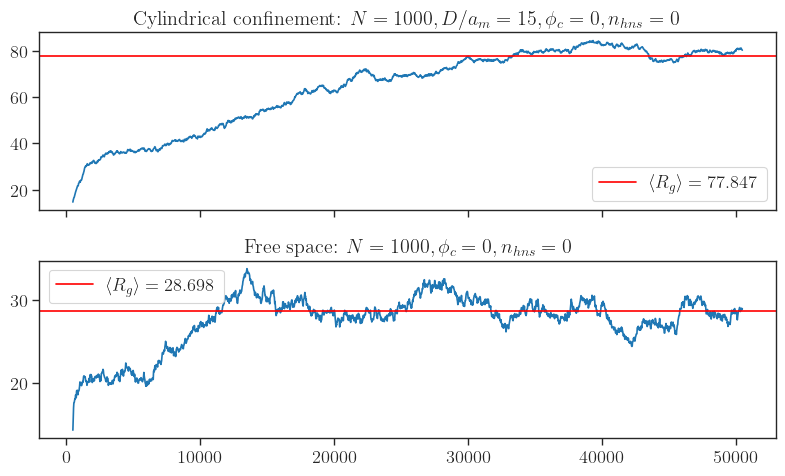

In [12]:
color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
plot_context = 'paper'
font_scale = 1.5
height = 5
aspect = 1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(aspect*height, height), sharex=True)
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
slice_id = 1000
ax[0].plot(0.005*gyr1[:,0],gyr1[:,1])
gyr1_mean = np.mean(gyr1[slice_id:,1])
ax[0].set_title(r'Cylindrical confinement: $N=1000, D/a_m=15, \phi_c=0, n_{{hns}}=0$')
ax[0].axhline(y=gyr1_mean,c='red',label=fr'$\langle R_g\rangle={round(gyr1_mean,3)}$')
#ax[0].axvline(x=0.005*gyr1[slice_id,0],c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={0.005*gyr1[slice_id,0]}$')
ax[0].legend()

ax[1].plot(0.005*gyr2[:,0],gyr2[:,1])
slice_id = 1000
gyr2_mean = np.mean(gyr2[slice_id:,1])
ax[1].set_title(r'Free space: $N=1000, \phi_c=0, n_{{hns}}=0$')
ax[1].axhline(y=gyr2_mean,c='red',label=fr'$\langle R_g\rangle={round(gyr2_mean,3)}$')
#ax[1].axvline(x=0.005*gyr2[slice_id,0],c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={0.005*gyr2[slice_id,0]}$')
ax[1].legend()
fig.tight_layout()
plt.show()

# Test measurements:

In [4]:
# free
glob('/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1l250nc0ens1.ring/N*')


[]

In [6]:
# confined
glob('/Users/amirhsi_mini/research_data/test_hns_cyl/N1000kbmm24nh0ac1r8lz675nc0ens1.ring/N*')

[]

In [9]:
sorted(glob('/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N*'))

['/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N200kbmm2r4.5lz75nh0ac1nc0ens5.j01.ring.all.lammpstrj.gz',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N200kbmm2r4.5lz75nh0ac1nc0ens5.j02.ring.all.lammpstrj.gz',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N200kbmm2r4.5lz75nh0ac1nc0ens5.j03.ring.all.lammpstrj.gz',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N200kbmm2r4.5lz75nh0ac1nc0ens5.j04.ring.all.lammpstrj.gz',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N200kbmm2r4.5lz75nh0ac1nc0ens5.j05.ring.all.lammpstrj.gz',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N200kbmm2r4.5lz75nh0ac1nc0ens5.j06.ring.all.lammpstrj.gz',
 '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N200kbmm2r4.5lz75nh0ac1nc0ens5.j07.ring.all.lammpst

In [10]:
%%time
topo = '/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring.nucleoid.data'
traj = ['/Users/amirhsi_mini/research_data/test_hns_cyl/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring/N200kbmm2r4.5lz75nh0ac1nc0ens5.ring.nucleoid.lammpstrj']
## 14 min for 2 trjs
## 9 min for N=200 no crowd no hns with all transformations, ndump=2000
## 9 min for N=200 no crowd no hns no need for all transformations, ndump=5000
trj_bond_lengths_mean = []
trj_cosine_corrs_mean = []
for i, trj in enumerate(traj):
    cell = mda.Universe(
        topo,
        trj,
        topology_format='DATA',
        format='LAMMPSDUMP',
        lammps_coordinate_convention='unscaled',
        unwrap_images=False,
        atom_style="id resid type x y z", 
        dt=5000*0.005
    )
    if i == 0:
        sliced_trj = cell.trajectory#[55000:]
    else:
        sliced_trj = cell.trajectory
    n_frames = len(sliced_trj)
    bug = cell.select_atoms('resid 1')  # the bug
    #workflow = [
    #    mda_trans.unwrap(cell.atoms),
    #    mda_trans.center_in_box(bug),
    #    mda_trans.wrap(cell.atoms)
    #]
    #cell.trajectory.add_transformations(*workflow)

    n_bonds = len(bug.bonds.indices)
    bond_lengths = np.zeros((n_bonds, 1), dtype=np.float64)
    cosine_corrs = np.zeros(n_bonds, dtype=np.float64)
    fsd_t = np.empty(0)
    gyr_t = np.empty(0)
    time = np.empty(0)
    time = np.empty(0)
    for _ in sliced_trj:
        # bug:
        # -various measures of chain size
        time = np.append(time,cell.trajectory.time)
        bond_dummy, cosine_dummy = correlations.bond_info(
            bug,
            'ring'
            )
        bond_lengths += bond_dummy
        cosine_corrs += cosine_dummy
        gyr_t = np.append(gyr_t, bug.radius_of_gyration())
        fsd_t = np.append(fsd_t, np.array([fsd(bug.positions)]), axis=0)
#        fsd_t = np.append(fsd_t, np.array([fsd(bug.positions)]), axis=0)
    
    bond_lengths_mean = bond_lengths / n_frames
    bonds_per_lag = np.arange(n_bonds, 0, -1)
    cosine_corrs_mean = cosine_corrs / (n_frames * bonds_per_lag)
    trj_cosine_corrs_mean.append(cosine_corrs_mean)
    bond_lengths_mean = bond_lengths_mean.reshape(n_bonds,)
    trj_bond_lengths_mean.append(bond_lengths_mean)  

CPU times: user 26.5 s, sys: 1.33 s, total: 27.8 s
Wall time: 15.2 s


In [27]:
(np.std(fsd_t, ddof=1) / np.sqrt(np.size(fsd_t)))/np.mean(fsd_t)

0.0006302105887061242

In [28]:
(np.std(gyr_t, ddof=1) / np.sqrt(np.size(gyr_t)))/np.mean(gyr_t)

0.0006903536853708228

## Radius of gyration and farthermost distance plot

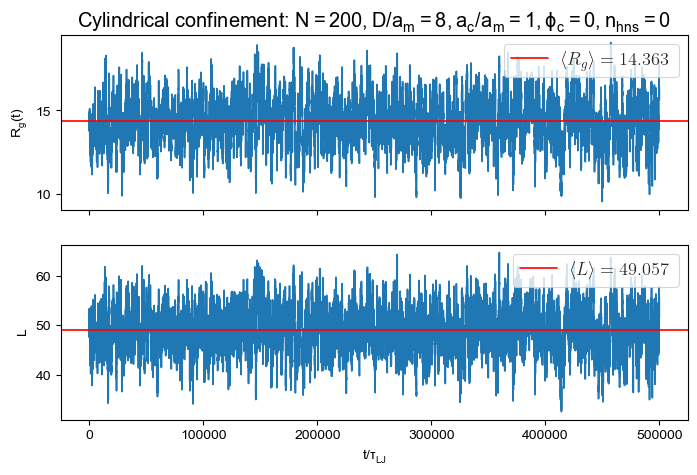

In [11]:
color_palette = 'tab10'
plot_context = 'paper'
font_scale = 1.5
height = 5
aspect = 1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(aspect*height, height), sharex=True)
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
slicer = 1000
ax[0].plot(time, gyr_t)
short_mean = np.mean(gyr_t[slicer:])
ax[0].axhline(y=short_mean,c='red',label=fr'$\langle R_g\rangle={round(short_mean,3)}$')
#ax[0].axvline(x=0.005*time[55000],c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={0.005*time[55000]}$')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$R_g(t)$')
ax[0].set_title(r'Cylindrical confinement: $N=200, D/a_m=8, a_c/a_m=1, \phi_c=0, n_{{hns}}=0$')
fsd_mean = np.mean(fsd_t[slicer:])
ax[1].plot(time, fsd_t)
ax[1].axhline(y=fsd_mean,c='red',label=fr'$\langle L\rangle={round(fsd_mean,3)}$')
#ax[1].axvline(x=0.005*time[slicer],c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={0.005*time[55000]}$')
ax[1].set_ylabel(r'$L$')
ax[1].legend(loc='upper right')
ax[1].set_xlabel(r'$t/\tau_{LJ}$')
plt.show()
fig.savefig('chainsize.pdf')

## Persistance length

In [12]:
import scipy
def fit_exponential_decay(x, y):
    r"""Fit a function to an exponential decay

    .. math::  y = \exp\left(- \frac{x}{a}\right)

    Parameters
    ----------
    x, y : array_like
      The two arrays of data

    Returns
    -------
    a : float
      The coefficient *a* for this decay

    Notes
    -----
    This function assumes that data starts at 1.0 and decays to 0.0

    """
    def exp_func(x, a):
        return np.exp(-1*x/a)
    a = scipy.optimize.curve_fit(exp_func, x, y)[0][0]
    return a
def fit_exponential_growth(x, y):
    r"""Fit a function to an exponential decay

    .. math::  y = \exp\left(- \frac{x}{a}\right)

    Parameters
    ----------
    x, y : array_like
      The two arrays of data

    Returns
    -------
    a : float
      The coefficient *a* for this decay

    Notes
    -----
    This function assumes that data starts at 1.0 and decays to 0.0

    """
    def exp_func(x, a):
        return np.exp(x/a)
    a = scipy.optimize.curve_fit(exp_func, x, y)[0][0]
    return a

In [13]:
mean_bond = np.mean(trj_bond_lengths_mean[0])
mean_bond

0.9698892110723104

In [14]:
#trj_cosine_corrs = np.mean(trj_cosine_corrs_mean,axis=0)
bond_lags = np.arange(1, n_bonds+1)
per_to_bond = fit_exponential_decay(
    bond_lags,
    trj_cosine_corrs_mean[0]
)
per_to_bond 

4.255141222467432

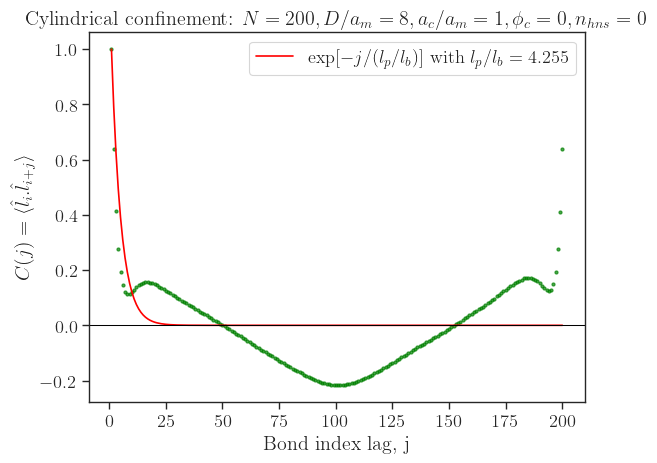

In [15]:
color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'paper'
font_scale = 1.5
height = 4
aspect = 1.618
ylabel_pad = 50
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': False,
    'sharex': False,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    #'ncol': 1,
    #'bbox_to_anchor': (1., 0.95),
    'frameon': False,
    #'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1
}
fig, ax = plt.subplots(nrows=1, ncols=1)#,figsize=((16/9)*3, 3))
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)

ax.scatter(bond_lags,trj_cosine_corrs_mean[0],c='green',marker='o',s=5,alpha=0.7)
#ax.scatter(bond_lags,trj_cosine_corrs_mean[1],marker='o',s=5,alpha=0.7)
ax.plot(bond_lags,np.exp(-(bond_lags-1)/per_to_bond),color='red',label=fr'$\exp[-j/(l_p/l_b)]$ with $l_p/l_b={round(per_to_bond,3)}$')
#short_mean = np.mean(long[55000:,1])
ax.axhline(y=0,c='black', lw=0.75)
#ax.axvline(x=0.005*long[55000,0],c='gray',ls='--',label='Equilibrium reached!')
ax.legend()
#ax.set_ylabel(r'$R_g(t)$')
ax.set_xlabel('Bond index lag, j')
#bond_grid.set_ylabels(r'$\langle\cos(\theta_{i,i+j})\rangle$')
ax.set_ylabel(r'$C(j)=\langle\hat{l}_i.\hat{l}_{i+j}\rangle$')
#ax.text(120, 0.7, fr'$l_p/l_b={round(per_length,3)}$')
ax.set_title(r'Cylindrical confinement: $N=200, D/a_m=8, a_c/a_m=1, \phi_c=0, n_{{hns}}=0$')
plt.show()
fig.savefig('bond_correlations.pdf')

### Non-linear fit

In [16]:
def fit_exponential_non_linear_decay(x, y):
    r"""Fit a function to an exponential decay

    .. math::  y = \exp\left(- \frac{x}{a}\right)

    Parameters
    ----------
    x, y : array_like
      The two arrays of data

    Returns
    -------
    a : float
      The coefficient *a* for this decay

    Notes
    -----
    This function assumes that data starts at 1.0 and decays to 0.0

    """
    def exp_func(x, a, exponent):
        return np.exp(-1*x**exponent/a)
    a, exponent = scipy.optimize.curve_fit(exp_func, x, y)[0]
    return a, exponent

In [17]:
gyr = np.concatenate((gyr1,gyr2),axis=0)
gyr.shape

NameError: name 'gyr1' is not defined

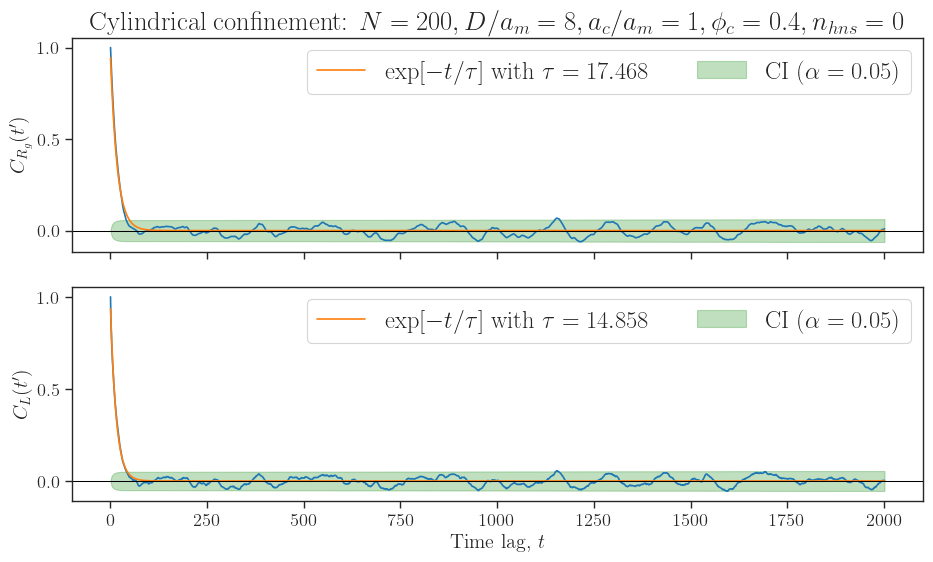

In [18]:
plot_context = 'paper'
font_scale = 2
height = 6
aspect = 1.618
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(aspect*height, height), sharex=True)
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)



gyr=gyr_t
acf_t = tsas.acf(
            gyr,
            nlags=2000,
            alpha=0.05,
        )
acf = acf_t[0]
acf_lag = np.arange(1,len(acf)+1)
lower_cl = acf_t[1][:, 0] - acf_t[0]
upper_cl = acf_t[1][:, 1] - acf_t[0]
decay_time = fit_exponential_decay(
    acf_lag,
    acf
)
ax = axes[0]
ax.plot(acf_lag, acf)
#ax.plot(acf_lag,np.exp(-1*acf_lag**decay_time[1]/decay_time[0]))
ax.plot(acf_lag,np.exp(-1*acf_lag/decay_time),label=fr'$\exp[-t/\tau]$ with $\tau={round(decay_time,3)}$')
ax.axhline(y=0,c='black', lw=0.75)
ax.fill_between(
            acf_lag,
            lower_cl,
            upper_cl,
            color='green',
            alpha=0.25,
            label=r'CI ($\alpha=0.05$)'
        )
ax.legend(ncols=2)
ax.set_title(r'Cylindrical confinement: $N=200, D/a_m=8, a_c/a_m=1, \phi_c=0.4, n_{{hns}}=0$')
#ax.set_xlabel(r'Time lag, $t^{\prime}$')
ax.set_ylabel(r'$C_{R_g}(t^{\prime})$')


acf_t = tsas.acf(
            fsd_t,
            nlags=2000,
            alpha=0.05,
        )
acf = acf_t[0]
acf_lag = np.arange(1,len(acf)+1)
lower_cl = acf_t[1][:, 0] - acf_t[0]
upper_cl = acf_t[1][:, 1] - acf_t[0]
decay_time = fit_exponential_decay(
    acf_lag,
    acf
)
ax = axes[1]
ax.plot(acf_lag, acf)
#ax.plot(acf_lag,np.exp(-1*acf_lag**decay_time[1]/decay_time[0]))
ax.plot(acf_lag,np.exp(-1*acf_lag/decay_time),label=fr'$\exp[-t/\tau]$ with $\tau={round(decay_time,3)}$')
ax.fill_between(
            acf_lag,
            lower_cl,
            upper_cl,
            color='green',
            alpha=0.25,
            label=r'CI ($\alpha=0.05$)'
        )
ax.legend(ncols=2)
ax.axhline(y=0,c='black', lw=0.75)
ax.set_xlabel(r'Time lag, $t$')
ax.set_ylabel(r'$C_{L}(t^{\prime})$')
fig.tight_layout()
fig.savefig('acf.pdf')
plt.show()

# Gyr and persistance length

In [19]:
gyr=gyr_t

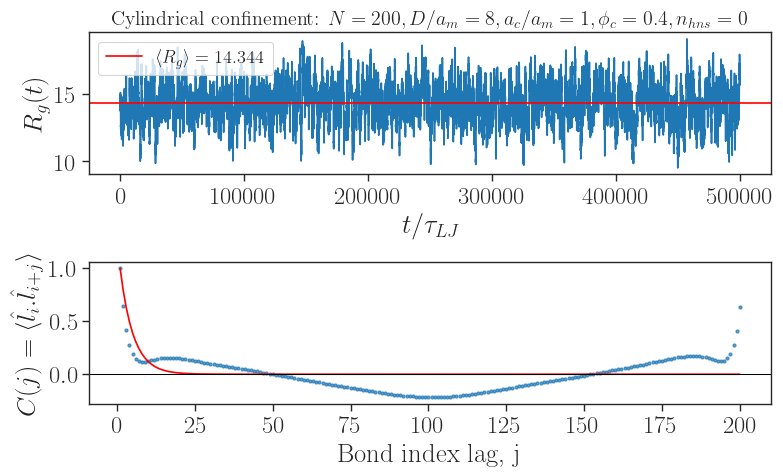

In [20]:
plot_context = 'paper'
font_scale = 1.5
height = 5
aspect = 1.618
rc_params= {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(aspect*height, height))
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)

ax = axes[0]

ax.plot(time,gyr)
short_mean = np.mean(gyr)
ax.axhline(y=short_mean,c='red',label=fr'$\langle R_g\rangle={round(short_mean,3)}$')
#ax.axvline(x=time,c='gray',ls='--',label=fr'$t/\tau_{{LJ}}={0.005*gyr[55019,0]}$')
ax.legend()
ax.set_ylabel(r'$R_g(t)$')
ax.set_xlabel(r'$t/\tau_{LJ}$')
ax.set_title(r'Cylindrical confinement: $N=200, D/a_m=8, a_c/a_m=1, \phi_c=0.4, n_{{hns}}=0$')

ax = axes[1]
ax.scatter(bond_lags,trj_cosine_corrs_mean[0],marker='o',s=5,alpha=0.7)
ax.plot(bond_lags,np.exp(-(bond_lags-1)/per_to_bond),color='red',label=fr'$\exp[-j/(l_p/l_b)]$ with $l_p/l_b={round(per_to_bond,3)}$')
#short_mean = np.mean(long[55000:,1])
ax.axhline(y=0,c='black', lw=0.75)
#ax.legend()
#ax.set_title(fr'Bond-bond ACF $C(j)$ for $t/\tau_{{LJ}}\ge{0.005*gyr[55019,0]}$')
ax.set_xlabel('Bond index lag, j')
ax.set_ylabel(r'$C(j)=\langle\hat{l}_i.\hat{l}_{i+j}\rangle$')
#ax.text(120, 0.7, fr'$l_p/l_b={round(per_length,3)}$')
fig.tight_layout()
plt.show()
fig.savefig('gyr-bond_correlations.pdf')